In [1]:
import json
import multiprocessing
import hashing.lsh_main as lsh
# import graph.graph_main as graph
import time
from pathlib import Path
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import graph.random_walk_ori as random_walk
import pandas as pd
import lshashpy3 as lshash
import math 

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [2]:
data = pd.read_csv('pH_accuracy.csv')
data = data['pH'].tolist()
# data = data[:5000]
len(data)

#define moving average function
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

#calculate moving average using previous 3 time periods

data = moving_avg(data, 200).tolist()


In [3]:
# df_ori = data[:15000]
# noise = np.random.normal(0,.008,len(data))
# generated = list(data + noise)

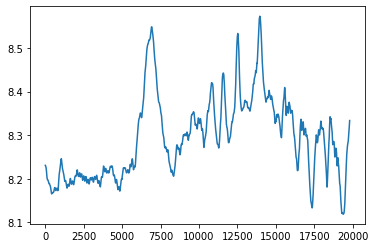

In [4]:
plt.plot(data)
plt.show()
# plt.plot(generated)
# plt.show()

In [5]:
window = 1000
segments = []
for i in range(3):
    segments += [data[i:i + window] + np.random.normal(0,.008, window) for i in range(0, len(data) - window, int(0.1 * window))]


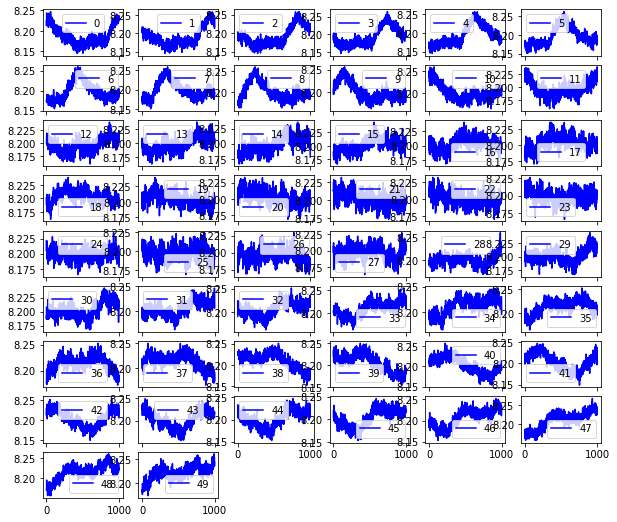

In [6]:
df_segments = pd.DataFrame(segments)
df_segments = df_segments.T

df_segments.iloc[: , :50].plot(subplots=True, layout=(10,6), figsize=(10, 10), legend = True, color = 'b')
plt.show()

# LSH

In [7]:
lsh = lshash.LSHash(8, len(segments[0]), num_hashtables=8)

for i in segments:
    lsh.index(i)

# results = [list(lsh.query(i)[0][0][0]) for i in segments]

# results = pd.DataFrame(results)
# results = results.T

# results.plot(subplots=True, layout=(5,5), figsize=(10, 5), legend = False, color = 'b')
# plt.show()


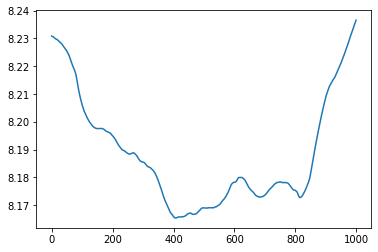

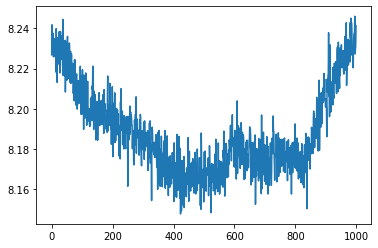

In [8]:
to_query = [data[i:i + window] for i in range(0, len(data) - window, window)]

plt.plot(to_query[0])
plt.show()

plt.plot(random.choice( lsh.query(to_query[0], distance_func="euclidean", num_results=10))[0][0])
plt.show()

# nn = lsh.query(to_query[0], distance_func="euclidean", num_results=10)
# for ((vec,extra_data),distance) in nn:
#     print( distance)
#     plt.plot(vec)
#     plt.show()
#     # len(segments)

In [9]:
# lsh_res = []
# for i in range(3):
#     results = [lsh.query(to_query[i])[0][0][0] for i in range(len(to_query))]
#     print(len(results))
#     res_lsh = []
#     for l in results: 
#         res_lsh += l
#     lsh_res.append(res_lsh)
    
lsh_res = []
n_top = 10
k = int(window * .03)
for i in tqdm(range(3)):
    temp = list(random.choice( lsh.query(to_query[0], distance_func="euclidean", num_results=n_top))[0][0])
    for i in range(1, len(to_query)): 
        s = list(random.choice( lsh.query(to_query[i], distance_func="euclidean", num_results=n_top))[0][0])
        temp_t = temp[-k:]
        s_h = s[:k]
        overlap = []
        for i in range(-k//2, k//2):
            overlap.append((1 - sigmoid(i))*temp_t[i + k//2] + sigmoid(i)*s_h[i + k//2])
#         for i in range(-1*k , 0):
#             temp[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
#         for i in range(0, k):
#             s[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
        temp[-k:] = overlap
        temp.extend(s[k:])
    lsh_res.append(temp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:18<00:00,  6.06s/it]


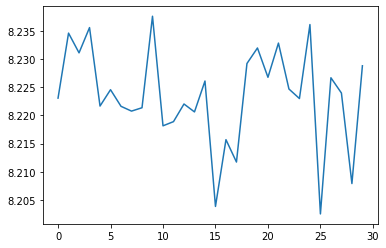

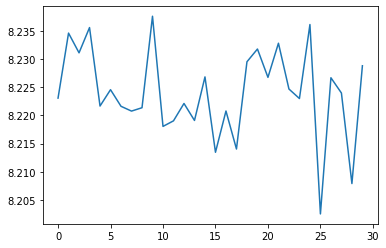

In [10]:

temp_t = [8.223067268392308, 8.234601459461013, 8.231100734977524, 8.235581871064525, 8.22165953679208, 8.224560530685782, 8.221611838752738, 8.220763007167054, 8.221360251440409, 8.237594346928871, 8.218151884601212, 8.218895522288742, 8.222024050647743, 8.220620320290683, 8.226100869913548]
s_h = [8.203848961187267, 8.215696132997543, 8.211725913440684, 8.229210929937185, 8.231961348404845, 8.226763106150951, 8.232830353263141, 8.22468453854455, 8.222993742737057, 8.236119151230762, 8.202521977215087, 8.226678129771793, 8.223971839312602, 8.20790959411677, 8.228807763790948]
overlap = [8.223067262513386, 8.234601443740704, 8.231100691184144, 8.23558183192035, 8.221659708846982, 8.224560630678013, 8.221613223056579, 8.220764322253114, 8.221361739634606, 8.237590699325827, 8.218047275961117, 8.219035501900985, 8.22211642622594, 8.21910516458973, 8.226828865800433, 8.213458114789788, 8.220780558368093, 8.214035448781532, 8.229513077383112, 8.231776057858188, 8.226748364641713, 8.23280261410438, 8.224680965828703, 8.222993194945538, 8.23611933326191, 8.20252268677957, 8.226677999791182, 8.223971827345048, 8.207909622847135, 8.22880776154009]

plt.plot(temp_t + s_h)
plt.show()
plt.plot(overlap)
plt.show()


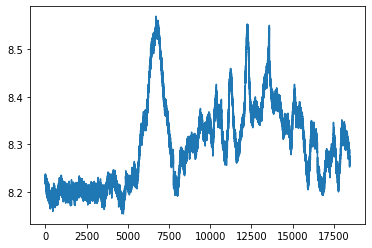

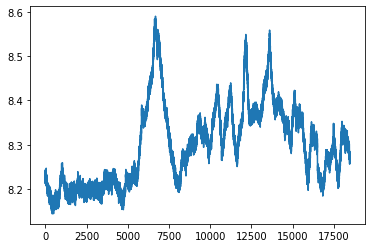

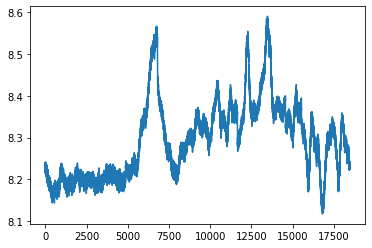

In [11]:
plt.plot(lsh_res[0])
plt.show()

plt.plot(lsh_res[1])
plt.show()

plt.plot(lsh_res[2])
plt.show()

# Graph

In [12]:
#Calculates the distance between two series. Given series A, B returns the Euclidean distance between A and B
def distance(a, b):
    return np.sqrt(np.sum((a - b)**2))
    
#The probability is converted according to the sorted distances, which adds up to 1
def distopro(a):
    a=len(a)
    if(a==3):
        b=[0.2,0.3,0.5]
    elif(a==4):
        b=[0.1,0.2,0.3,0.4]
    else:
        b=[0.04,0.12,0.2,0.28,0.36]
    return np.array(b)
        

#Input is the original data matrix, return is the relationship matrix relation_matrix, and probability matrix probability_matrix
#Data is the matrix of series, the first dimension is the number of series, and the second dimension is each series
#Window_size is the size of the window to calculate the distance, and k is the number of the nearest neighbors selected. Currently, 3,4,5 are supported
def transform(data, window_size, k):
    numOfSeq=data.shape[0]
    distance_matrix=np.ones([numOfSeq,numOfSeq],dtype = float)
    for i in range(numOfSeq):
        for j in range(numOfSeq):
            distance_matrix[i][j]=distance(data[i,data.shape[1]-window_size:],data[j,0:window_size])
    relation_matrix=np.ones([numOfSeq,k],dtype = int)
    subdistance_matrix=np.ones([numOfSeq,k],dtype = float)
    probability_matrix=np.ones([numOfSeq,k],dtype = float)
    for i in range(numOfSeq):
        relation_matrix[i]=distance_matrix[i].argsort()[::-1][data.shape[0]-k:]
        #print(relation_matrix[i])
#     print(relation_matrix[i])
    for i in range(numOfSeq):
        for j in range(k):
            subdistance_matrix[i][j]=distance_matrix[i][relation_matrix[i][j]]
    
    for i in range(numOfSeq):
        probability_matrix[i]=distopro(subdistance_matrix[i])
    
    
    return distance_matrix, subdistance_matrix ,relation_matrix, probability_matrix
            
      
#print(transform(np.array([[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0]]), 2, 3))


#Given the ID of the current series, the ID of the next series is generated randomly according to probability
def next_step(relation_array, probability_array):
    value=random.random()
#     print(value)
    threshold=[0]
    sum_value=0
    for i in range(len(probability_array)):
        sum_value=sum_value+probability_array[i]
        threshold.append(sum_value)
    for i in range(len(threshold)-1):
        if(value>threshold[i] and value<=threshold[i+1]):
            return relation_array[i]

#Given a relation matrix and a probability matrix, returns a series of length        
def random_walk(relation_matrix, probability_matrix, length):
    seq=[0]
    temp_id=0
    for i in range(length-1):
        temp_id=next_step(relation_matrix[temp_id],probability_matrix[temp_id])
        seq.append(temp_id)
        #print(temp_id)
    return np.array(seq)

In [13]:
seq=[0]

a,b,c,d=transform(np.array(segments), 100, 5)

In [14]:
graph_res = []
for i in range(3):
    path = random_walk( c, d, int(len(data)/window))
    print(path)
    temp=[]
    for s in path:
#         print(path[i], i)
        temp+=list(segments[s])
    graph_res.append(temp)
    print(len(graph_res))
    

[  0 428 248  68  77  86 473 482 113 500 509 329 527 484 325 145 154 352
 550]
1
[  0   9 380  11  20 218 227 425 434 254  74 272  92 479 299 119 132 519
 528]
2
[  0 428 437 256 307 148 148 510  71 458 282 480 170 166 175 373 551 182
  13]
3


In [15]:
print(graph_res[0][-3:-1])
print(graph_res[1][-3:-1])
print(graph_res[2][-3:-1])

[8.279117554787794, 8.270374493760224]
[8.35345601846227, 8.36502031813883]
[8.20390688601989, 8.208689888115908]


In [16]:

# res_lsh = pd.read_csv('example_data.csv')
# res_lsh = res_lsh['LSH'].tolist()

# res_graph = pd.read_csv('example_data.csv')
# res_graph = res_graph['Graph'].tolist()

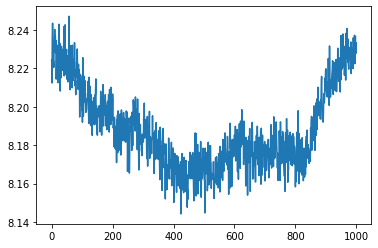

In [17]:
plt.plot(segments[0])
plt.show()

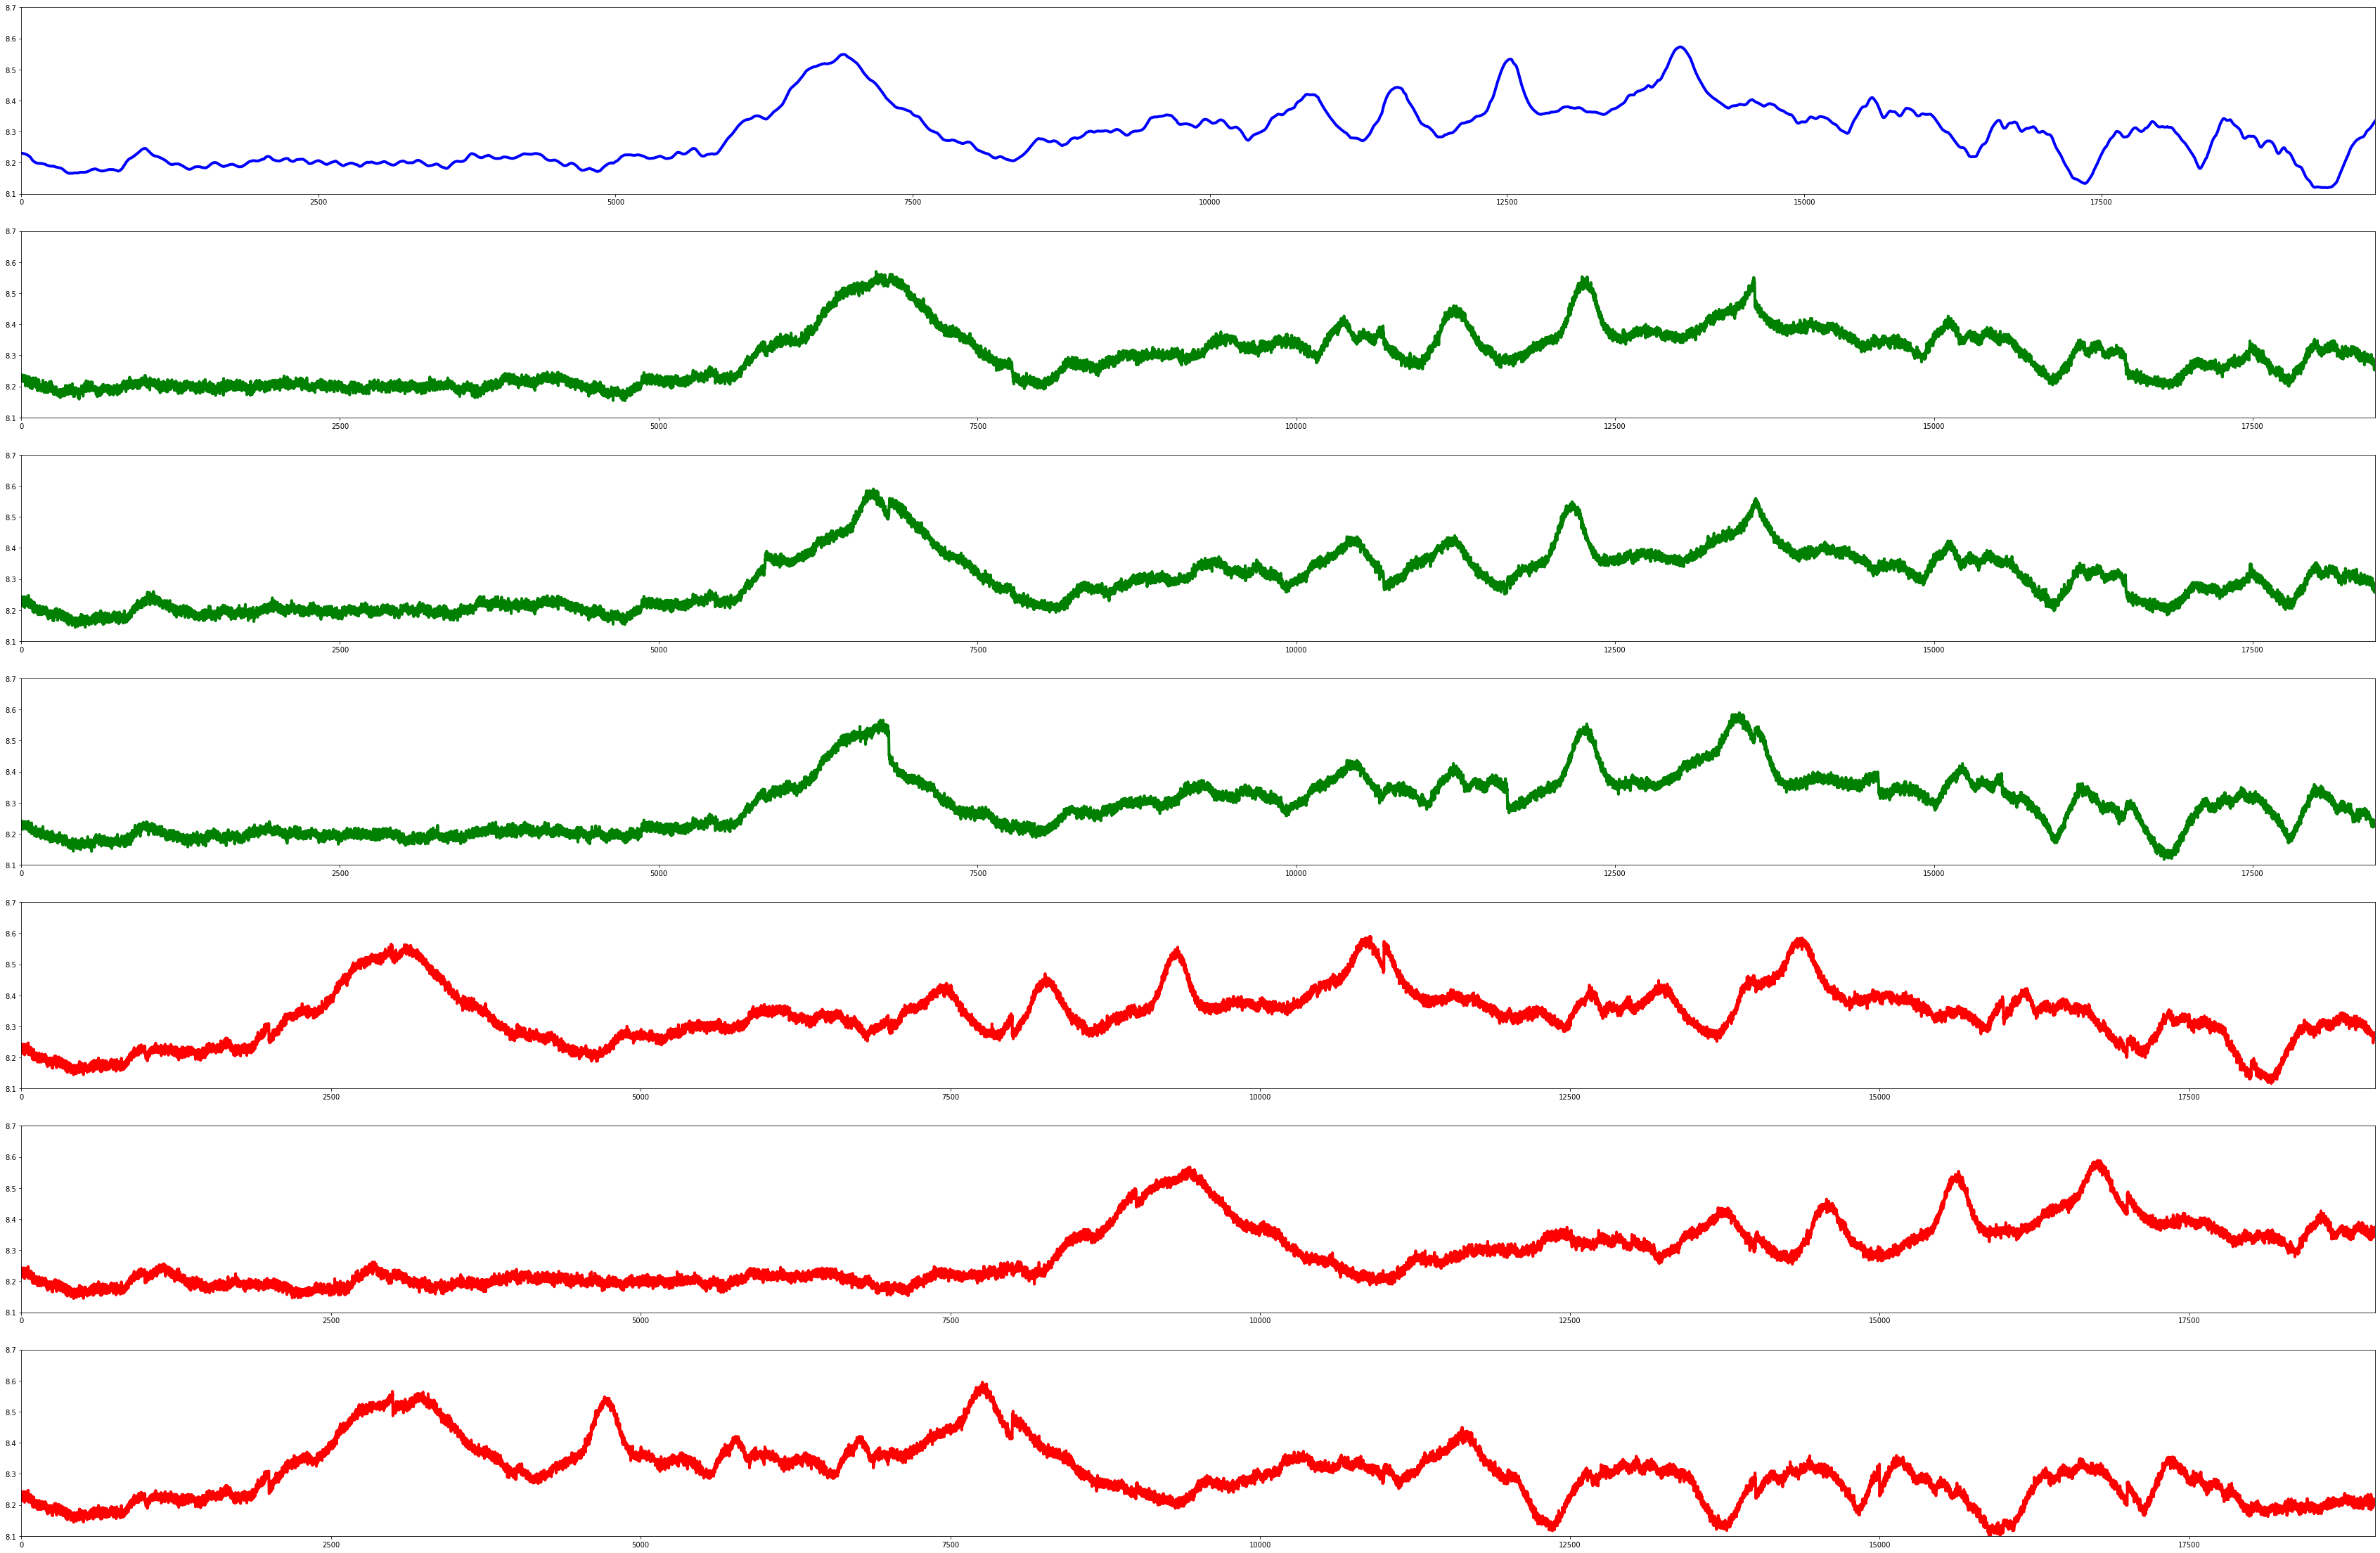

In [18]:
xi = list(range(10000))
# plot the index for the x-values 

plt.figure(figsize=(60, 40))
plt.subplot(7, 1, 1)

# plt.figure(figsize=(60, 8))
plt.plot(data,color='blue',linewidth=4.0, label='Original')
plt.xlim(0,len(data))
plt.ylim(8.1,8.7)
# plt.legend(loc="upper left", prop={'size': 36})

# plt.show()

plt.subplot(7, 1, 2)

# plt.figure(figsize=(60, 8))
plt.plot(lsh_res[0],color='green',linewidth=4.0, label='LSH1')
plt.xlim(0,len(lsh_res[0]))
plt.ylim(8.1,8.7)
# plt.legend(loc="upper left", prop={'size': 36})

plt.subplot(7, 1, 3)

# plt.figure(figsize=(60, 8))
plt.plot(lsh_res[1],color='green',linewidth=4.0, label='LSH2')
plt.xlim(0,len(lsh_res[1]))
plt.ylim(8.1,8.7)
# plt.legend(loc="upper left", prop={'size': 36})

plt.subplot(7, 1, 4)

# plt.figure(figsize=(60, 8))
plt.plot(lsh_res[2],color='green',linewidth=4.0, label='LSH3')
plt.xlim(0,len(lsh_res[1]))
plt.ylim(8.1,8.7)
# plt.legend(loc="upper left", prop={'size': 36})


plt.subplot(7, 1, 5)

# plt.figure(figsize=(60, 8))
plt.plot(graph_res[0],color='red',linewidth=4.0, label='Graph1')
plt.xlim(0,len(graph_res[0]))
plt.ylim(8.1,8.7)

plt.subplot(7, 1, 6)

# plt.figure(figsize=(60, 8))
plt.plot(graph_res[1],color='red',linewidth=4.0, label='Graph2')
plt.xlim(0,len(graph_res[1]))
plt.ylim(8.1,8.7)


plt.subplot(7, 1, 7)

# plt.figure(figsize=(60, 8))
plt.plot(graph_res[2],color='red',linewidth=4.0, label='Graph3')
plt.xlim(0,len(graph_res[2]))
plt.ylim(8.1,8.7)

# plt.legend(loc="upper left", prop={'size': 36})
# plt.show()
plt.savefig('plot_lsh_graph.pdf',dpi=1600,
            bbox_inches = 'tight')



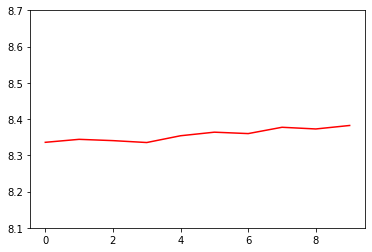

In [19]:
plt.plot(lsh_res[1][5830:5840],color='red')
plt.ylim(8.1,8.7)
plt.show()

# Metrics

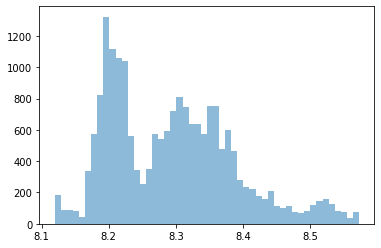

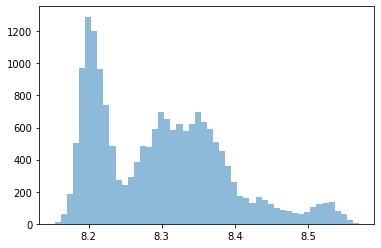

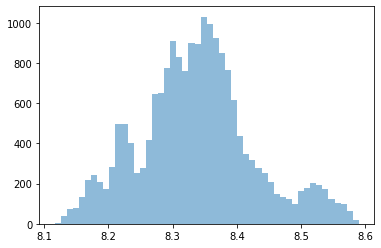

In [20]:
plt.hist(data, bins=50, alpha=0.5)
plt.show()
plt.hist(lsh_res[0], bins=50, alpha=0.5)
plt.show()
plt.hist(graph_res[0], bins=50, alpha=0.5)
plt.show()


NameError: name 'res_lsh' is not defined

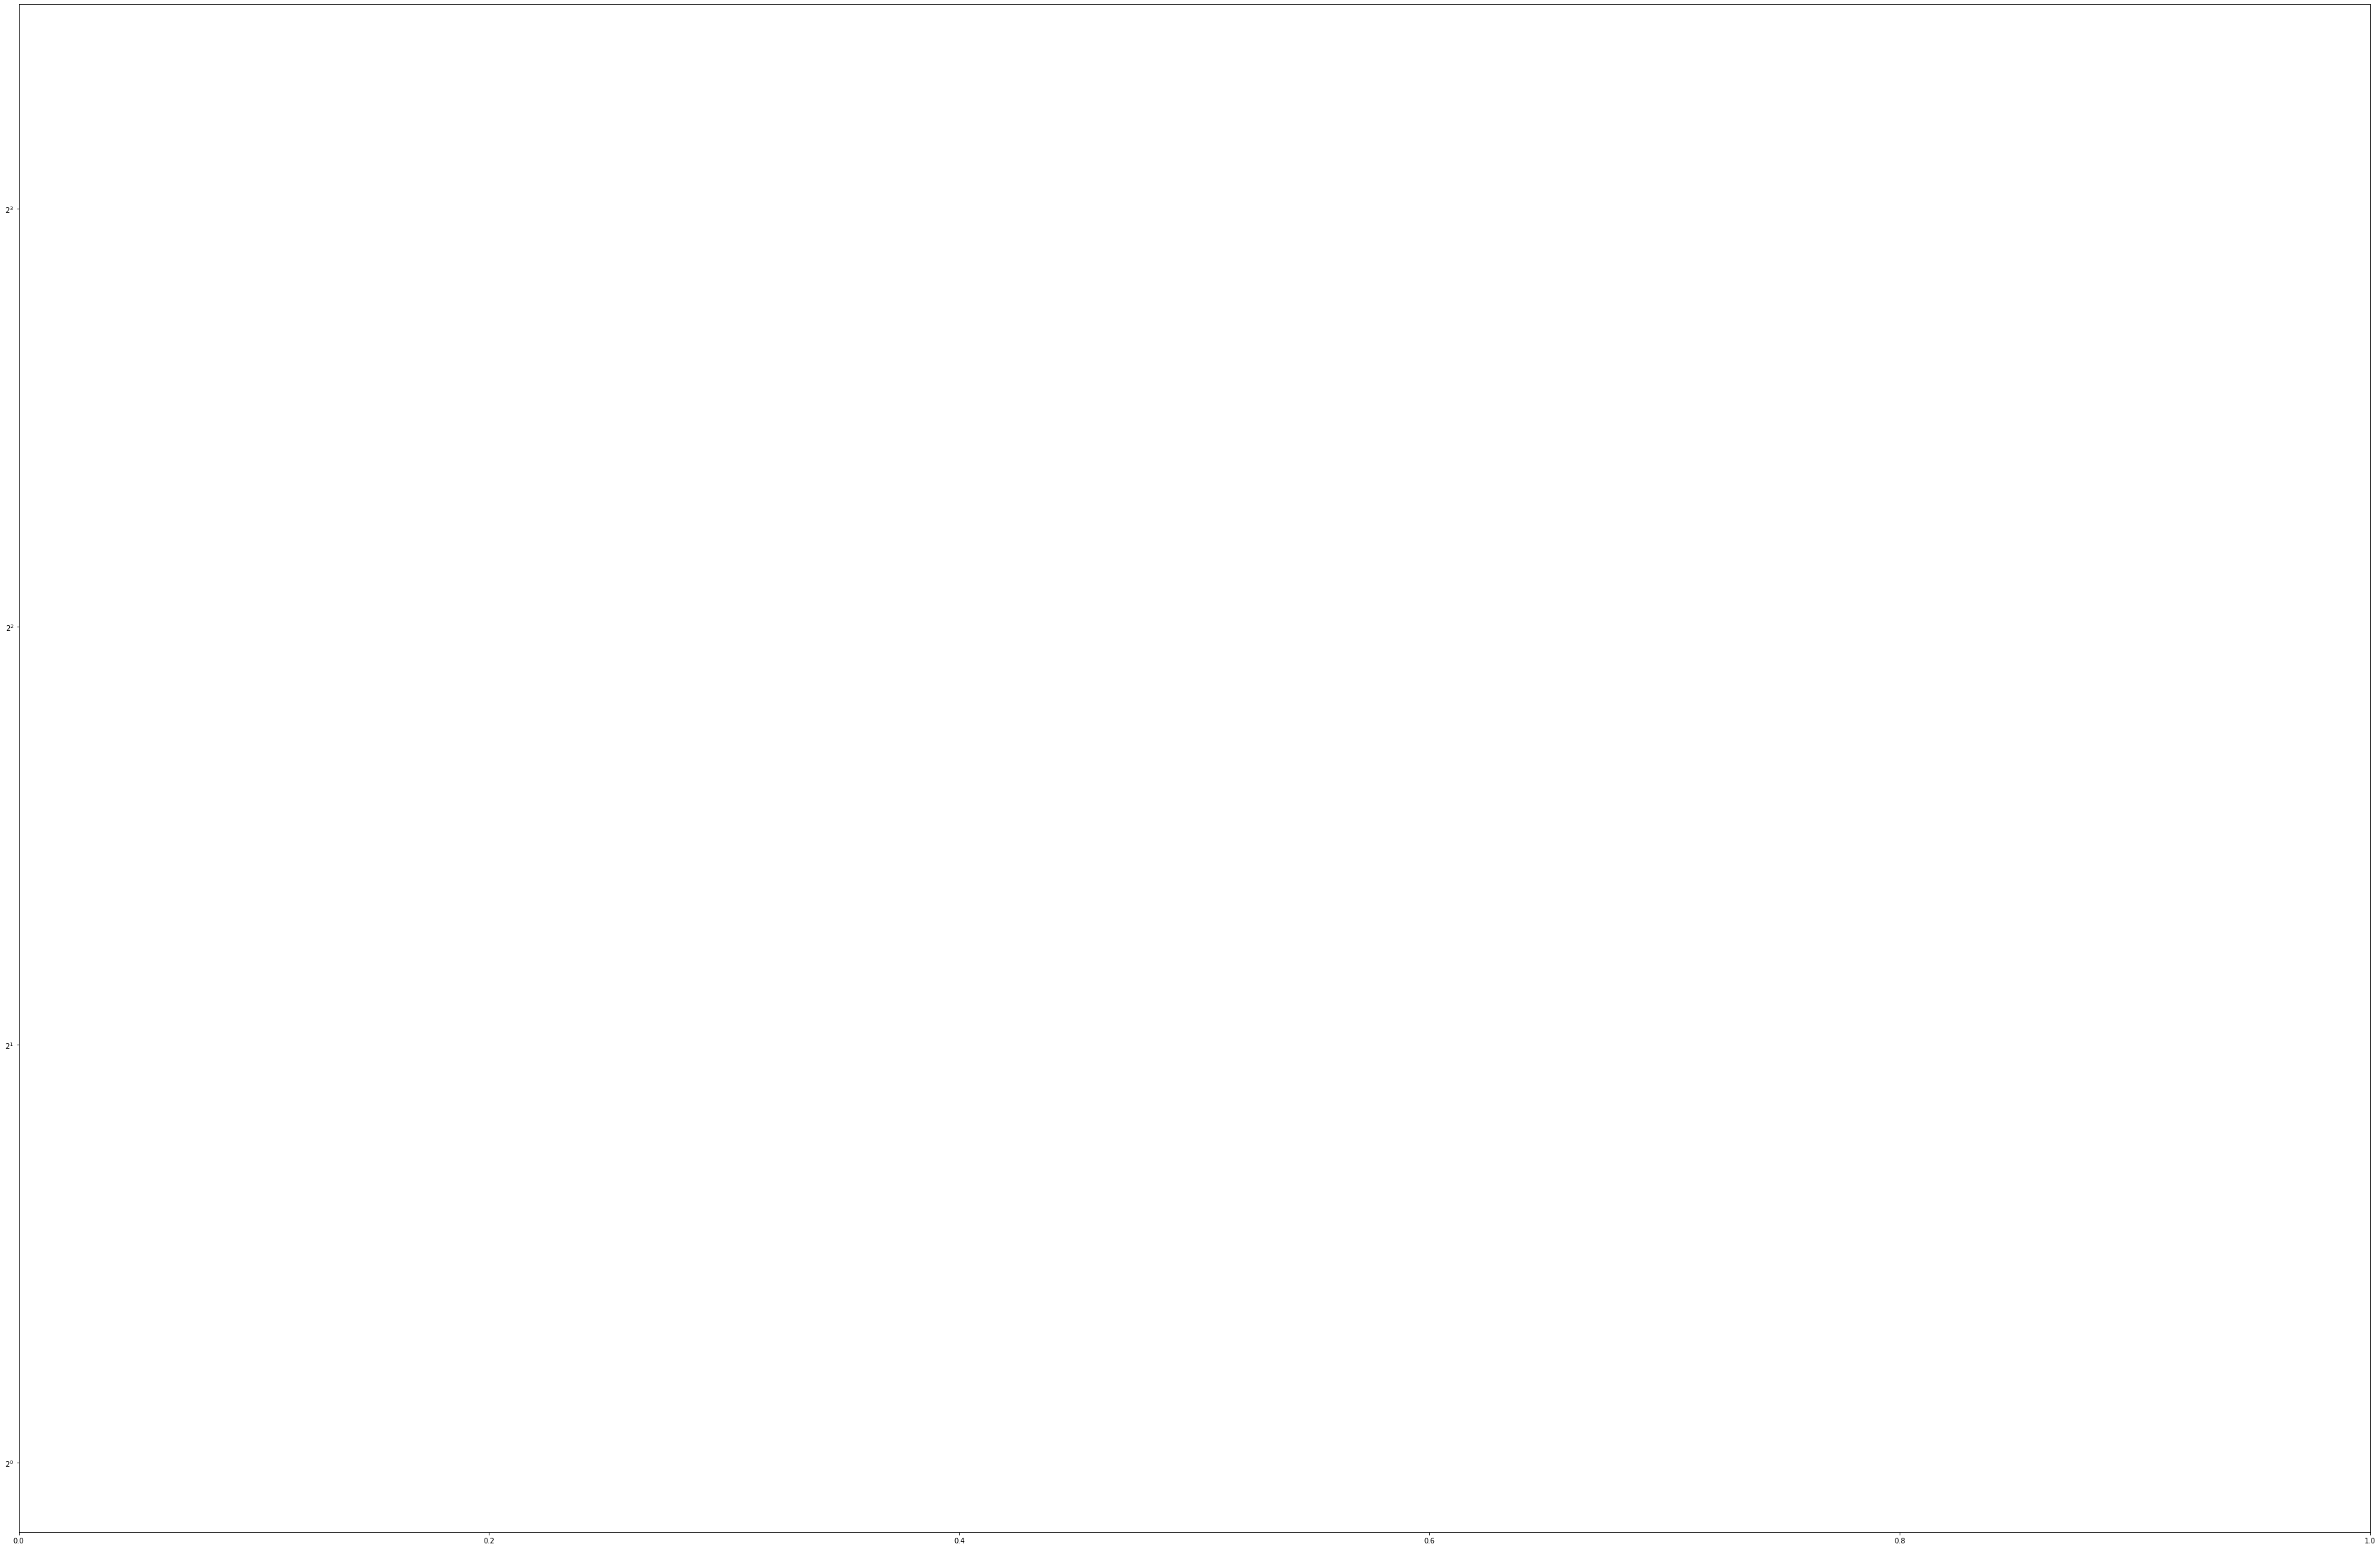

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(60, 40))

plt.style.use('seaborn-deep')

plt.yscale('log',base=2) 
plt.hist([data, res_lsh, res_graph], bins=10, label=['Original', 'LSH', 'Graph'])

plt.legend(loc="upper right", prop={'size': 80})

plt.savefig('plot_distribution.pdf',dpi=1600,
            bbox_inches = 'tight')
# plt.show()